In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Rescaling,BatchNormalization, Dropout,GlobalAveragePooling2D
from keras.models import Sequential
from keras import regularizers
from keras import layers


In [26]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/neu-surface-defect-database/NEU-DET/train/images",
    image_size=(128, 128),
    batch_size=32,
    color_mode="grayscale",
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/neu-surface-defect-database/NEU-DET/validation/images",
    image_size=(128, 128),
    batch_size=32,
    color_mode="grayscale",
    label_mode="categorical"
)


Found 1440 files belonging to 6 classes.
Found 360 files belonging to 6 classes.


In [27]:
print(train_ds.class_names)


['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [28]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)


(32, 128, 128, 1)
(32, 6)


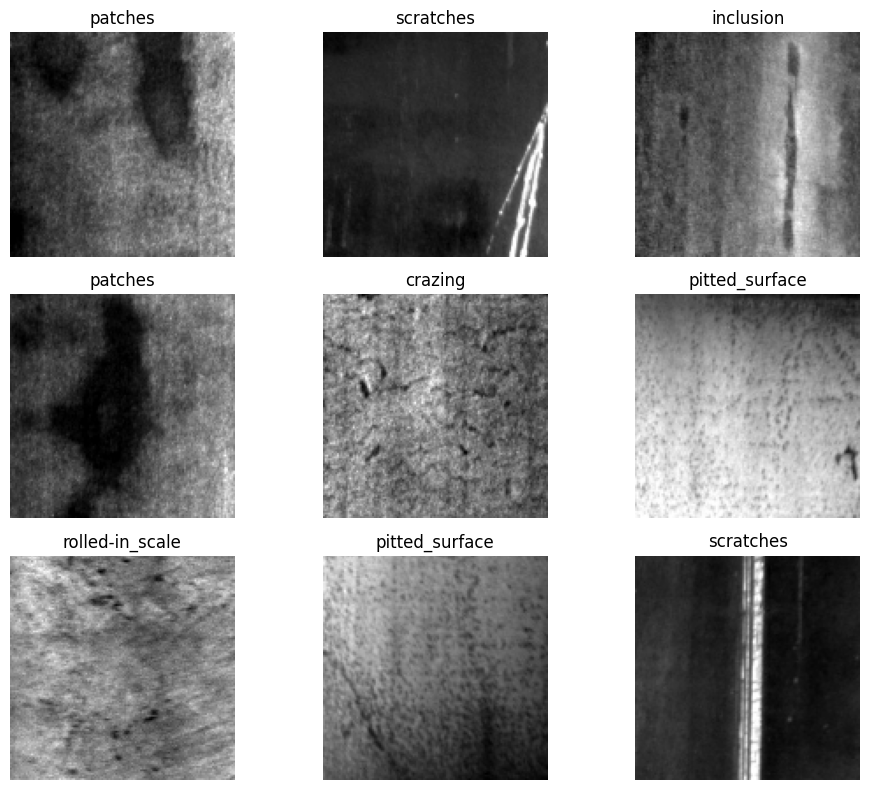

In [29]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 8))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap="gray")
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [30]:

preprocess = Sequential([
    Rescaling(1./255)
])

In [31]:
sample = images[0:1]   # one image
scaled = preprocess(sample)

print(sample.numpy().min(), sample.numpy().max())
print(scaled.numpy().min(), scaled.numpy().max())

0.0 185.75977
0.0 0.7284697


In [32]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal",input_shape=(128, 128, 1)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),  # 20% = 72 degrees
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomBrightness(0.2),
], name="data_augmentation")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
model=Sequential()
model.add(data_augmentation)

model.add(Rescaling(1./255,input_shape=(128, 128, 1)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())
    
model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(6,activation='softmax'))


model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,366 (435.02 KB)

 Trainable params: 110,662 (432.27 KB)

 Non-trainable params: 704 (2.75 KB)

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint(
    'best_defect_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [36]:
model.fit(train_ds,validation_data=val_ds,epochs=50,callbacks=[checkpoint,early_stop])

Epoch 1/50


E0000 00:00:1769694322.470421      55 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3248 - loss: 2.1829
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to best_defect_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3267 - loss: 2.1759 - val_accuracy: 0.1667 - val_loss: 1.9711
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5182 - loss: 1.4531
Epoch 2: val_accuracy improved from 0.16667 to 0.21944, saving model to best_defect_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5192 - loss: 1.4509 - val_accuracy: 0.2194 - val_loss: 2.3256
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5894 - loss: 1.2563
Epoch 3: val_accuracy improved from 0.21944 to 0.23889, saving model to best_defect_model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5898 - loss: 1.2561 - val_accuracy: 0.2389 - val_loss: 3.1680
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6466 - loss: 1.1439
Epoch 4: val_accuracy did not improve 

In [37]:
print(train_ds.class_names)


['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [38]:
best_model = tf.keras.models.load_model("best_defect_model.keras")


In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))



print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
[[60  0  0  0  0  0]
 [ 0 57  0  1  0  2]
 [ 0  0 57  3  0  0]
 [ 0  3  0 57  0  0]
 [ 2  0  0 19 39  0]
 [ 0  0  0  0  0 60]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.95      0.95      0.95        60
           2       1.00      0.95      0.97        60
           3       0.71      0.95      0.81        60
           4       1.00      0.65      0.79        60
           5       0.97      1.00      0.98        60

    accuracy                       

In [ ]:
model.sa